## Восстановление ф-ии плотности вероятности. 

### Принцип максимума энтропии.

Основная задача - создать такую модель случайного процесса, которая максимально бы соответствовала наблюдаемым значением этой случайной величины.

Существует большое число методов оценки ф-ии плотности распределения. В этой заметке будет рассмотрен метод максимума энтропии. Основная идея заключается в следующем: если выводы основываются на неполной информации, она должна выбираться из распределения вероятности, максимизируещего энтропию при заданных ограничениях на распределение. Таким образом энтропия является функционалом, заданном на некотором множестве возможных распределений.

Наша задача нахождения оптимального с точки зрения энтропии распределения сводится к вариационной задаче оптимизации следующего функционала:

$$h(X) = - \int_{-\infty}^{\infty} f_{X}(x) log (f_{X}(x)) \,dx$$

при следующих заданных ограничениях:

$$\int_{-\infty}^{\infty} f_{X}(x) \,dx = 1$$

$$\int_{-\infty}^{\infty} f_{X}(x) g_{i}(x) \,dx = \alpha_{i}$$

Используя метод Лагранжа для для решения этой задачи условной оптимизации, получаем следующий вид функционала:

$$J(f) = \int_{-\infty}^{\infty} \left[ -f_{X}(x)log(f_{X}(x)) + \lambda_0 f_{X}(x) + \sum_{i=1}^{m} \lambda_i g_i(x) f_{X}(x) \right] \,dx$$

Дифференцируем интеграл по $f_{X}(x)$ и приравниваем нулю, получаем:

$$-1 - log(f_{X}(x)) + \lambda_0 + \sum_{i=1}^{m} \lambda_i g_i(x) = 0$$

Выражаем $f_{X}(x)$:

$$f_{X}(x) = \exp(-1 + \lambda_0 + \sum_{i=1}^{m} \lambda_i g_i(x))$$

Таким образом мы получили параметрический вид распределения, соответствующего принципу максимальной энтропии. Конкретный вид распределения зависит от выбора параметров $\lambda_i$. Для поиска оптимальных значений $\lambda_i$ с точки зрения соответствия $k$ наблюдаемым значениям $u_n$ будем использовать принцип максимального правдоподобия, функционал для которого выглядит следующим образом:

$$L(\lambda) = \sum_{n = 0}^{k - 1} ln (f_{X}(x))$$

Требуется найти $\lambda$, для которых $L(\lambda)$ максимальна при выполнении ограничения на нормировку $\int_{-\infty}^{\infty} f_{X}(x) \,dx = 1$

### Теперь мы готовы поработать ручками :)

Реализуем класс для модели нашего распределения (ExpPolyDistribution). 

Пусть состояние модели определяется двумя массивами:

    - restrictions: список функций ограничений
    - lambdas: вектор параметров модели
    
Для максимизации функционала при условии заданных ограничений будем использовать [метод последовательного квадратичного программирования](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [1]:
import numpy as np

import scipy.integrate as integrate

from scipy.optimize.slsqp import approx_jacobian
from scipy.optimize import minimize
from scipy.optimize.slsqp import _epsilon

def jac_factory(fun, epsilon):
    """
    Creates function for numerical jacobian approximation.

    :param fun: Function for evaluation.
    :param epsilon: The perturbation used to determine the partial derivatives.
    :return: Function for numerical jacobian approximation.
    """
    def jac(x, *args):
        return approx_jacobian(x, fun, epsilon, *args)
    return jac

class ExpPolyDistribution:

    def __init__(self, restrictions, lambdas=None):

        if restrictions is None:
            raise ValueError("restrictions is mandatory param")
        if lambdas is None:
            lambdas = np.zeros(len(restrictions) + 1)
        if len(lambdas) - 1 != len(restrictions):
            raise ValueError("Lambdas params number should be as restrictions plus one")

        self.lambdas = lambdas
        self.restrictions = np.concatenate(([lambda x: 1], restrictions), axis=0)

    def pdf(self, x):
        return self.__pdf(x, self.lambdas)

    def log_likelihood(self, observations):
            return -self.__inv_log_likelihood(self.lambdas, observations)

    def fit(self, X):

        # Lets integration interval to be hardcoded
        a, b = -50, 50

        constraints = (
            # Probability of entire sample space is equal to one
            {
                'type': 'eq',
                'fun' : lambda lambdas: np.array([integrate.quad(lambda x: self.__pdf([x], lambdas)[0], a, b)[0] - 1])
            }
        )

        result = minimize(
                self.__inv_log_likelihood, self.lambdas, args=(X,),
                jac=jac_factory(self.__inv_log_likelihood, _epsilon),
                constraints=constraints, method='SLSQP', options={'disp': True}
        )

        self.lambdas = result.x
        return self

    def __pdf(self, x, lambdas):
        qp_pdf = lambda p: np.exp(
            -1 + sum(list(map(lambda fx_tuple: fx_tuple[1] * fx_tuple[0](p), zip(self.restrictions, lambdas))))
        )
        return list(map(qp_pdf, x))

    def __inv_log_likelihood(self, lambdas, observations):
            return -np.sum(np.log(self.__pdf(observations, lambdas)))



### Теперь пора проверить какие мы молодцы и все ли сделано правильно.

Сгенерируем 30 случайных величин используя нормальное распределение со средним 2 и дисперсией 1.

In [2]:
nr = np.random.normal(2, 1, 30)

Зададим ограничения на первый и второй момент для нашей модели.

In [3]:
restrictions = [
    lambda x: x,
    lambda x: x**2
]

Создадим нашу модель с заданными ограничениями и обучим ее.

In [4]:
np.seterr(over='ignore')
ep_distr = ExpPolyDistribution(restrictions)
ep_distr = ep_distr.fit(nr)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 41.0595841182
            Iterations: 37
            Function evaluations: 55
            Gradient evaluations: 37


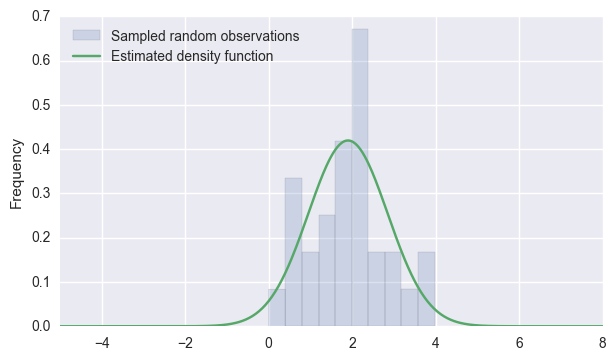

In [5]:
%matplotlib inline

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (7.0, 4.0)
seaborn.mpl.rcParams['savefig.dpi'] = 100

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

data = pd.Series(nr)
ax = data.plot(kind='hist', bins=10, normed=True, alpha=0.2, label='Sampled random observations', legend=True)

x = np.linspace(-5, 8, 500)
y = ep_distr.pdf(x)

p = pd.Series(y, x).plot(label='Estimated density function', legend=True, ax=ax)
